# Regression Model

We implemented a linear regression model to predict `Mean_Relative_MCL` and `...` from socioeconomic features (e.g. `Median_Income`, `Poverty_Rate`). 

Question of interest: 
Can we use socioeconomic variables (income and poverty rate) to predict the degree of water contamination in U.S. counties, using linear regression as a predictive model?

## Preprocessing the data


In [15]:
"""Load libraries"""

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

colors = [
    sns.color_palette("viridis", as_cmap=True)(0.2),
    sns.color_palette("viridis", as_cmap=True)(0.4),
    sns.color_palette("viridis", as_cmap=True)(0.7),
    sns.color_palette("viridis", as_cmap=True)(0.9)
]

In [16]:
"""Load data"""

# List of file names
files = [f"df{i}.csv" for i in range(1, 13)]
dfs = [pd.read_csv(file, sep=",", encoding="latin1") for file in files]

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

(1499860, 22)


In [ ]:
"""Data preprocessing: Create separate data frames for 2023"""

#df["CollectionDate"] = pd.to_datetime(df["CollectionDate"], errors='coerce')

df.loc[:, "Total_Samples"] = df["MCL_Exceeded"] + df["MRL_Not_Exceeded"]

# Create separate file for 2023 data only
df_2023 = df[df["CollectionDate"].dt.year == 2023].copy()

# Aggregate data per county
df_counties = df_2023.groupby("County").agg(
    State=('State', lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]), 
    Total_Samples=('Total_Samples', 'sum'),
  

    MCL_Not_Exceeded=('MCL_Not_Exceeded', 'sum'),
    MCL_Exceeded=('MCL_Exceeded', 'sum'),

    Max_Relative_MCL=('Relative_MCL', 'max'),
    Median_Income=('Median_Income', 'max'),
    Poverty_Rate=('Poverty_Rate', 'max')
).reset_index()



# Compute Mean_Relative_MCL where MCL_Exceeded == 1
df_mean_mcl = df_2023[df_2023["MCL_Exceeded"] == 1].groupby("County")["Relative_MCL"].mean().reset_index()
df_mean_mcl.rename(columns={"Relative_MCL": "Mean_Relative_MCL"}, inplace=True)

# Merge back Mean_Relative_MCL values

df_counties = df_counties.merge(df_mean_mcl, on="County", how="left")
df_counties["Mean_Relative_MCL"] = df_counties["Mean_Relative_MCL"].fillna(0)

# Compute percentage of contaminated samples for MRL and MCL
df_counties["Ratio_MCL"] = df_counties["MCL_Exceeded"] / df_counties["Total_Samples"] * 100


# Drop multiple columns
df_counties = df_counties.drop(['State', 'County','MCL_Not_Exceeded','MCL_Exceeded','Max_Relative_MCL',], axis=1)

# Filter for ratio_mcl > 5%
df_counties = df_counties[df_counties['Ratio_MCL'] > 5]


df_filtered = df_counties.copy()

# Display updated dataframe
display(df_counties.sample(5))



,Total_Samples,Median_Income,Poverty_Rate,Mean_Relative_MCL,Ratio_MCL
543,111,56237.0,16.7,3.227778,16.216216
741,1382,72065.0,10.5,2.056507,5.282200
556,228,76559.0,11.2,1.358333,9.210526
83,437,82414.0,11.3,1.656034,6.636156
294,113,60599.0,14.3,3.737500,8.849558


In [29]:
"""Apply Boxcox transformation"""

from scipy.stats import boxcox

# Apply Box-Cox transformation to the two columns
df_filtered["boxcox_Mean_Relative_MCL"], lambda_mean = boxcox(df_filtered["Mean_Relative_MCL"])
df_filtered["boxcox_Ratio_MCL"], lambda_ratio = boxcox(df_filtered["Ratio_MCL"])

# Drop any remaining NaNs
df_filtered = df_filtered.dropna()

# Show shape
df_filtered.shape

(86, 17)

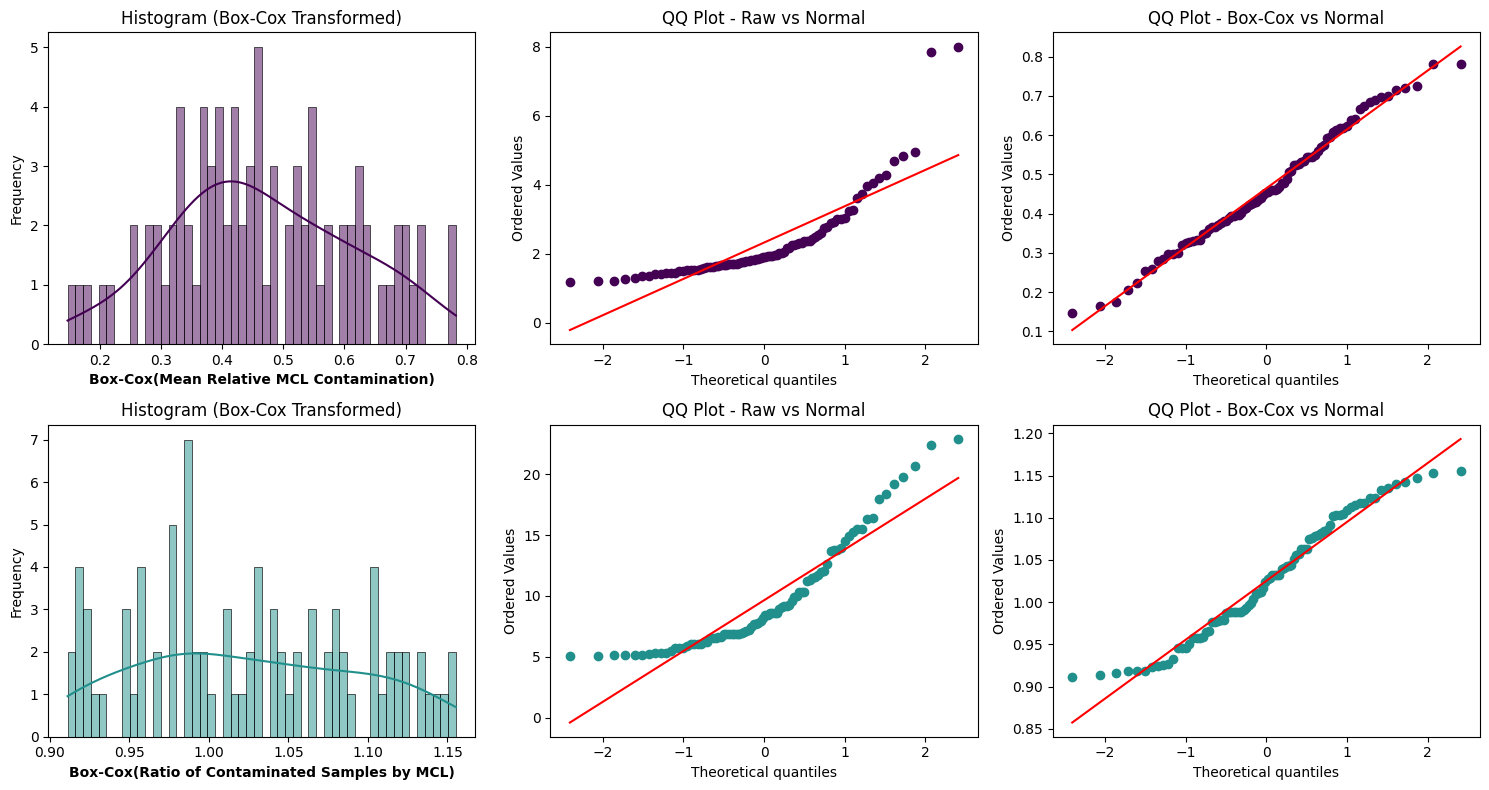

In [30]:
"""Assumption Check: Normality of Residuals (BoxCox Transformation) """

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Raw and Box-Cox-transformed data (already stored in df_filtered)
data_raw_mean = df_filtered["Mean_Relative_MCL"]
data_raw_ratio = df_filtered["Ratio_MCL"]
data_bc_mean = df_filtered["boxcox_Mean_Relative_MCL"]
data_bc_ratio = df_filtered["boxcox_Ratio_MCL"]

# Define colors
colors = ["#440154", "#21908C"]  # Purple and Teal

# Create 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# --- Row 1: Mean_Relative_MCL
sns.histplot(data_bc_mean, bins=50, kde=True, color=colors[0], ax=axes[0, 0])
axes[0, 0].set_xlabel("Box-Cox(Mean Relative MCL Contamination)", fontweight="bold")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Histogram (Box-Cox Transformed)")

# QQ Plot - Raw data vs Normal
stats.probplot(data_raw_mean, dist="norm", plot=axes[0, 1])
axes[0, 1].get_lines()[0].set_color(colors[0])
axes[0, 1].get_lines()[1].set_color("red")
axes[0, 1].set_title("QQ Plot - Raw vs Normal")

# QQ Plot - Box-Cox vs Normal
stats.probplot(data_bc_mean, dist="norm", plot=axes[0, 2])
axes[0, 2].get_lines()[0].set_color(colors[0])
axes[0, 2].get_lines()[1].set_color("red")
axes[0, 2].set_title("QQ Plot - Box-Cox vs Normal")

# --- Row 2: Ratio_MCL
sns.histplot(data_bc_ratio, bins=50, kde=True, color=colors[1], ax=axes[1, 0])
axes[1, 0].set_xlabel("Box-Cox(Ratio of Contaminated Samples by MCL)", fontweight="bold")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Histogram (Box-Cox Transformed)")

# QQ Plot - Raw data vs Normal
stats.probplot(data_raw_ratio, dist="norm", plot=axes[1, 1])
axes[1, 1].get_lines()[0].set_color(colors[1])
axes[1, 1].get_lines()[1].set_color("red")
axes[1, 1].set_title("QQ Plot - Raw vs Normal")

# QQ Plot - Box-Cox vs Normal
stats.probplot(data_bc_ratio, dist="norm", plot=axes[1, 2])
axes[1, 2].get_lines()[0].set_color(colors[1])
axes[1, 2].get_lines()[1].set_color("red")
axes[1, 2].set_title("QQ Plot - Box-Cox vs Normal")

plt.tight_layout()
plt.show()

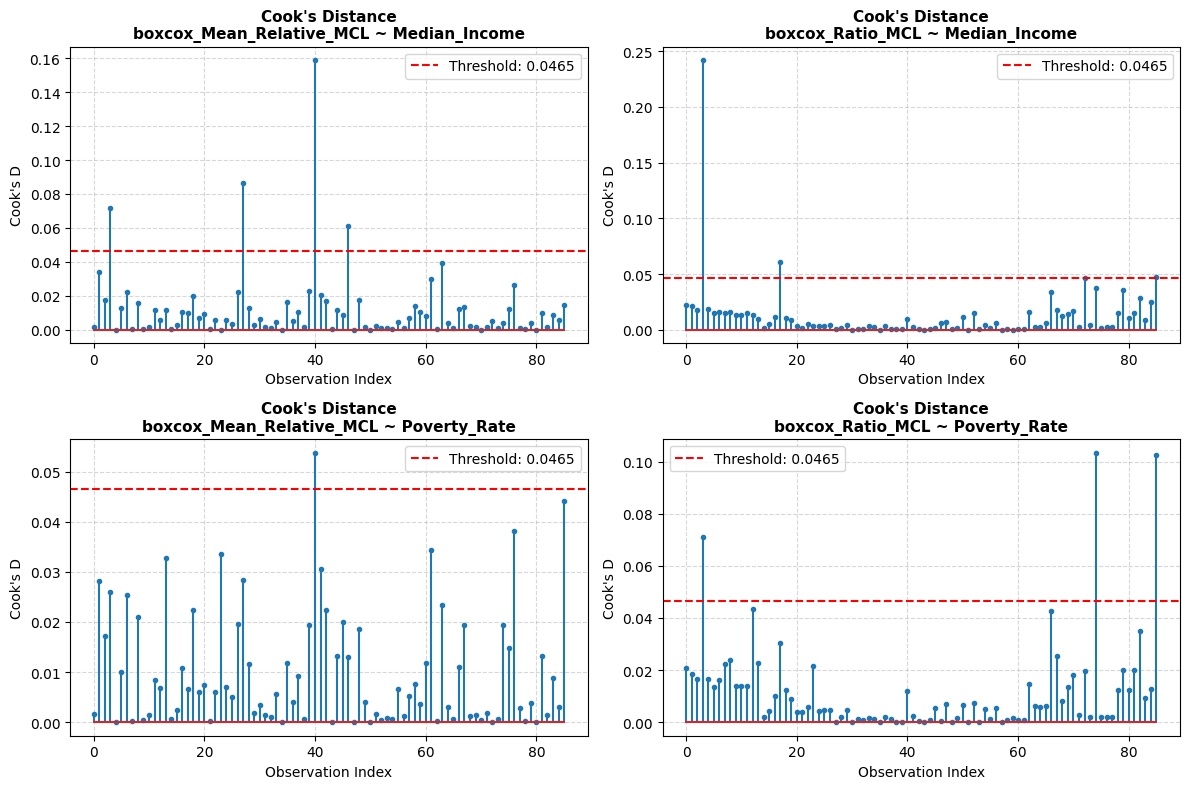

(79, 17)

In [31]:
"""Check: Influential outliers"""


import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Updated model pairs (referencing the original column names for plotting)
models = [
    ("Median_Income", "boxcox_Mean_Relative_MCL"),
    ("Median_Income", "boxcox_Ratio_MCL"),
    ("Poverty_Rate", "boxcox_Mean_Relative_MCL"),
    ("Poverty_Rate", "boxcox_Ratio_MCL")
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (x_col, y_col) in enumerate(models):
    # Prepare data
    df_subset = df_filtered[[x_col, y_col]].dropna()
    X = sm.add_constant(df_subset[[x_col]])
    y = df_subset[y_col]

    # Fit model
    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    # Plot Cook's Distance
    ax = axes[i]
    markerline, stemlines, baseline = ax.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=".")
    threshold = 4 / len(df_subset)
    ax.axhline(threshold, color="red", linestyle="--", label=f"Threshold: {threshold:.4f}")
    ax.set_title(f"Cook's Distance\n{y_col} ~ {x_col}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Observation Index")
    ax.set_ylabel("Cook's D")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

# ---------- Remove Influential Outliers ---------- #

# Track indices of all outliers
all_outlier_indices = set()

for x_col, y_col in models:
    df_subset = df_filtered[[x_col, y_col]].dropna()
    X = sm.add_constant(df_subset[[x_col]])
    y = df_subset[y_col]

    # Fit model
    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    threshold = 4 / len(df_subset)

    # Identify outliers and collect indices
    subset_indices = df_subset.index
    outliers = subset_indices[cooks_d > threshold]
    all_outlier_indices.update(outliers)

# Remove from original df_filtered
df_filtered = df_filtered.drop(index=all_outlier_indices).reset_index(drop=True)

# Final shape
df_filtered.shape

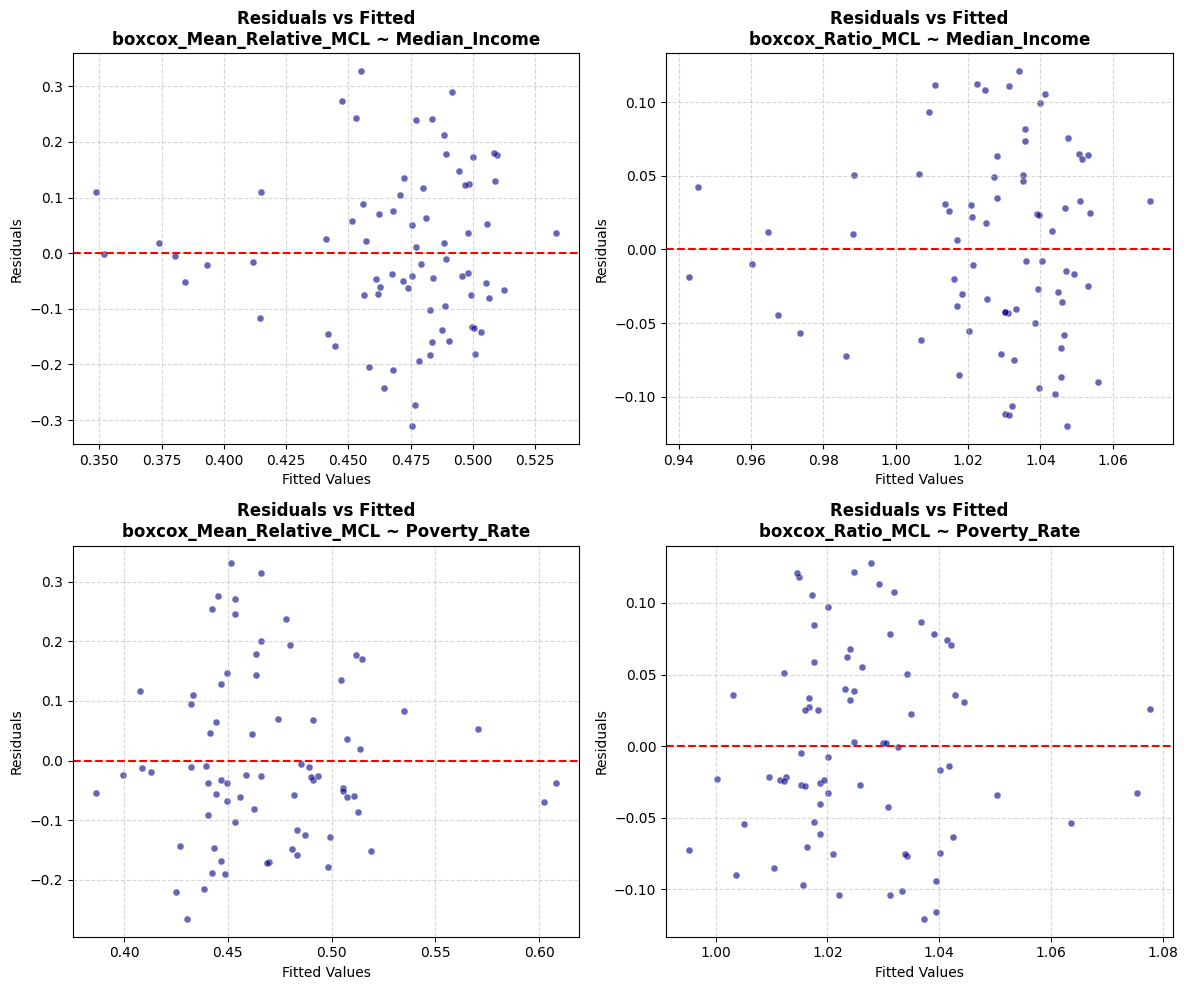

In [ ]:
"""Residuals vs Fitted"""

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Define model pairs using Box-Cox transformed target variables
models = [
    ("Median_Income", "boxcox_Mean_Relative_MCL"),
    ("Median_Income", "boxcox_Ratio_MCL"),
    ("Poverty_Rate", "boxcox_Mean_Relative_MCL"),
    ("Poverty_Rate", "boxcox_Ratio_MCL")
]

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (x_col, y_col) in enumerate(models):
    X = df_filtered[[x_col]].values
    y = df_filtered[y_col].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred

    # Plot residuals vs. fitted values
    ax = axes[i]
    sns.scatterplot(x=y_pred, y=residuals, ax=ax, color="darkblue", s=25, alpha=0.6)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_title(f"Residuals vs Fitted\n{y_col} ~ {x_col}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Fitted Values", fontsize=10)
    ax.set_ylabel("Residuals", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

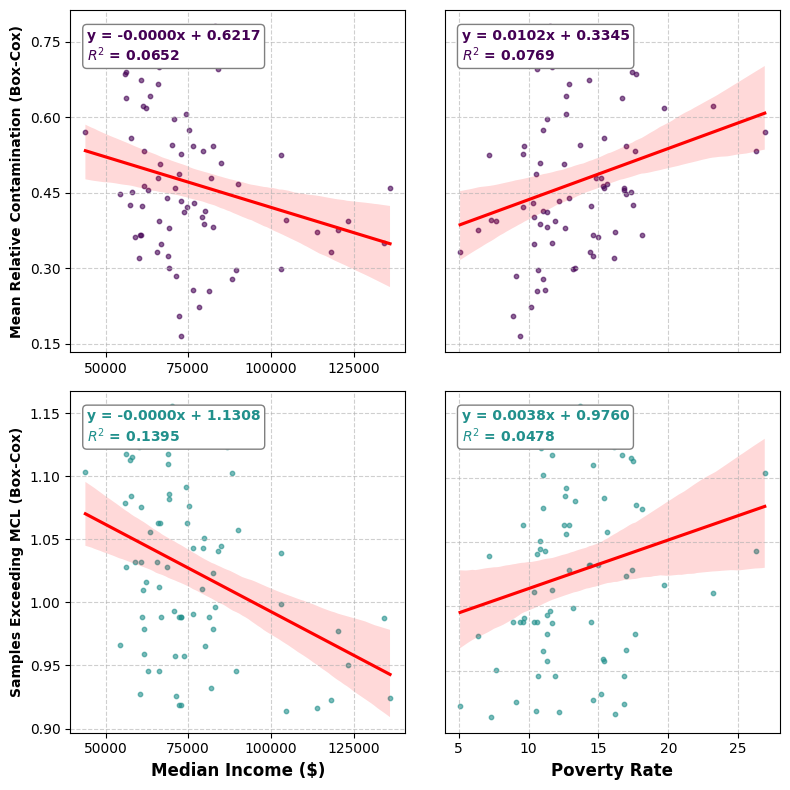

In [ ]:
"""Linear Regression Model"""

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.ticker as mticker

# Define function to add R² and regression line equation
def add_regression_text(ax, x, y, color):
    x_vals = df_filtered[x].values.reshape(-1, 1)
    y_vals = df_filtered[y].values
    model = LinearRegression().fit(x_vals, y_vals)
    r2 = r2_score(y_vals, model.predict(x_vals))
    
    equation = f"y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}\n$R^2$ = {r2:.4f}"
    
    ax.text(0.05, 0.85, equation, transform=ax.transAxes, 
            fontsize=10, color=color, fontweight="bold",
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# Create a two-column figure layout
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

colors = ["#440154", "#21908C"]  # consistent color scheme

# Plot 1: Median Income vs BoxCox Mean Relative Contamination
sns.regplot(data=df_filtered, x="Median_Income", y="boxcox_Mean_Relative_MCL", 
            scatter_kws={'color': colors[0], 'alpha': 0.6, 's': 10}, 
            line_kws={'color': 'red'}, ax=axes[0, 0])

axes[0, 0].set_xlabel("Median Income", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Mean Relative Contamination (Box-Cox)", fontsize=10, fontweight="bold")
axes[0, 0].set_title("Median Income vs Box-Cox Mean Relative Contamination", fontsize=10, fontweight="bold")
add_regression_text(axes[0, 0], "Median_Income", "boxcox_Mean_Relative_MCL", colors[0])

# Plot 2: Median Income vs BoxCox Ratio MCL
sns.regplot(data=df_filtered, x="Median_Income", y="boxcox_Ratio_MCL", 
            scatter_kws={'color': colors[1], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[1, 0])

axes[1, 0].set_xlabel("Median Income ($)", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Samples Exceeding MCL (Box-Cox)", fontsize=10, fontweight="bold")
axes[1, 0].set_title("Median Income vs Box-Cox Contaminated Samples", fontsize=12, fontweight="bold")
add_regression_text(axes[1, 0], "Median_Income", "boxcox_Ratio_MCL", colors[1])

# Plot 3: Poverty Rate vs BoxCox Mean Relative Contamination
sns.regplot(data=df_filtered, x="Poverty_Rate", y="boxcox_Mean_Relative_MCL", 
            scatter_kws={'color': colors[0], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[0, 1])

axes[0, 1].set_xlabel("Poverty Rate", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("Box-Cox Mean Relative Contamination", fontsize=12, fontweight="bold")
axes[0, 1].set_title("Poverty Rate vs Box-Cox Mean Relative Contamination", fontsize=10, fontweight="bold")
add_regression_text(axes[0, 1], "Poverty_Rate", "boxcox_Mean_Relative_MCL", colors[0])

# Plot 4: Poverty Rate vs BoxCox Ratio MCL
sns.regplot(data=df_filtered, x="Poverty_Rate", y="boxcox_Ratio_MCL", 
            scatter_kws={'color': colors[1], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[1, 1])

axes[1, 1].set_xlabel("Poverty Rate", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Contaminated Samples Ratio (Box-Cox)", fontsize=12, fontweight="bold")
axes[1, 1].set_title("Poverty Rate vs Box-Cox Contaminated Samples", fontsize=10, fontweight="bold")
add_regression_text(axes[1, 1], "Poverty_Rate", "boxcox_Ratio_MCL", colors[1])

# Clean up axis labels and ticks
for ax in axes.flat:
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_title("")

axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")
axes[0, 1].set_yticks([])
axes[1, 1].set_yticks([])
axes[0, 1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axes[1, 1].tick_params(left=False, labelleft=False)

# Adjust spacing
plt.tight_layout()

# Format axis ticks
for ax in axes.flatten():
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

plt.show()

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

# List of model configs using Box-Cox transformed targets
models = [
    ("Median_Income", "boxcox_Mean_Relative_MCL"),
    ("Median_Income", "boxcox_Ratio_MCL"),
    ("Poverty_Rate", "boxcox_Mean_Relative_MCL"),
    ("Poverty_Rate", "boxcox_Ratio_MCL"),
]

# Loop through models
for x_col, y_col in models:
    X = df_filtered[[x_col]].values
    y = df_filtered[y_col].values
    
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    results.append({
        "Predictor (X)": x_col,
        "Response (Y)": y_col,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "R²": round(r2, 4)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display
results_df

,Predictor (X),Response (Y),MSE,RMSE,R²
0,Median_Income,boxcox_Mean_Relative_MCL,0.0195,0.1397,0.0652
1,Median_Income,boxcox_Ratio_MCL,0.0040,0.0631,0.1395
2,Poverty_Rate,boxcox_Mean_Relative_MCL,0.0193,0.1388,0.0769
3,Poverty_Rate,boxcox_Ratio_MCL,0.0044,0.0663,0.0478
